In [3]:
import numpy as np
import math
import pandas as pd
import cv2
import os
#import tqdm
#from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json
from keras import regularizers

#from keras.initializers import he_normal


In [4]:
target_size = [608, 608]

target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

class_num = 1     ## item

categories = ['bom'] # details of classes

In [5]:
num_image_folder = []
drg_image = []

for i in range(1, 28):
    drg_folder = 'drg_test_' + str(i)
    drg_directory = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/' + drg_folder
    inter_var_1 = drg_directory + '/{}'
    drg_folder = [inter_var_1.format(i) for i in os.listdir(drg_directory)]
    num_image_folder.append(len(drg_folder))
    drg_image.append(drg_folder)

print('Number of images in folders = ', num_image_folder)

num_images = len(drg_image)

print('Number of image folders = ', num_images)


Number of images in folders =  [36, 36, 36, 42, 36, 41, 35, 54, 54, 40, 106, 54, 61, 53, 98, 97, 95, 99, 12, 32, 45, 45, 45, 47, 46, 66, 58]
Number of image folders =  27


In [6]:
## drg_image above is a list of lists. We need to flatten this : 

from itertools import chain

k = list(chain.from_iterable(map(list, drg_image)))
drg_image = k
drg_image.sort() # Sorting the list

print(len(drg_image))

1469


In [207]:
drg_image[0]

'/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_1/1001.jpg'

In [7]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(drg_image)):
    bgr_image = cv2.imread(drg_image[i]) ## Loading image
    
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(drg_image[i])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1469


image_serial  rows  columns
1466  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754
1467  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754
1468  /Users/subrata/workstation/jupyterFiles/yolo_d...  1240     1754

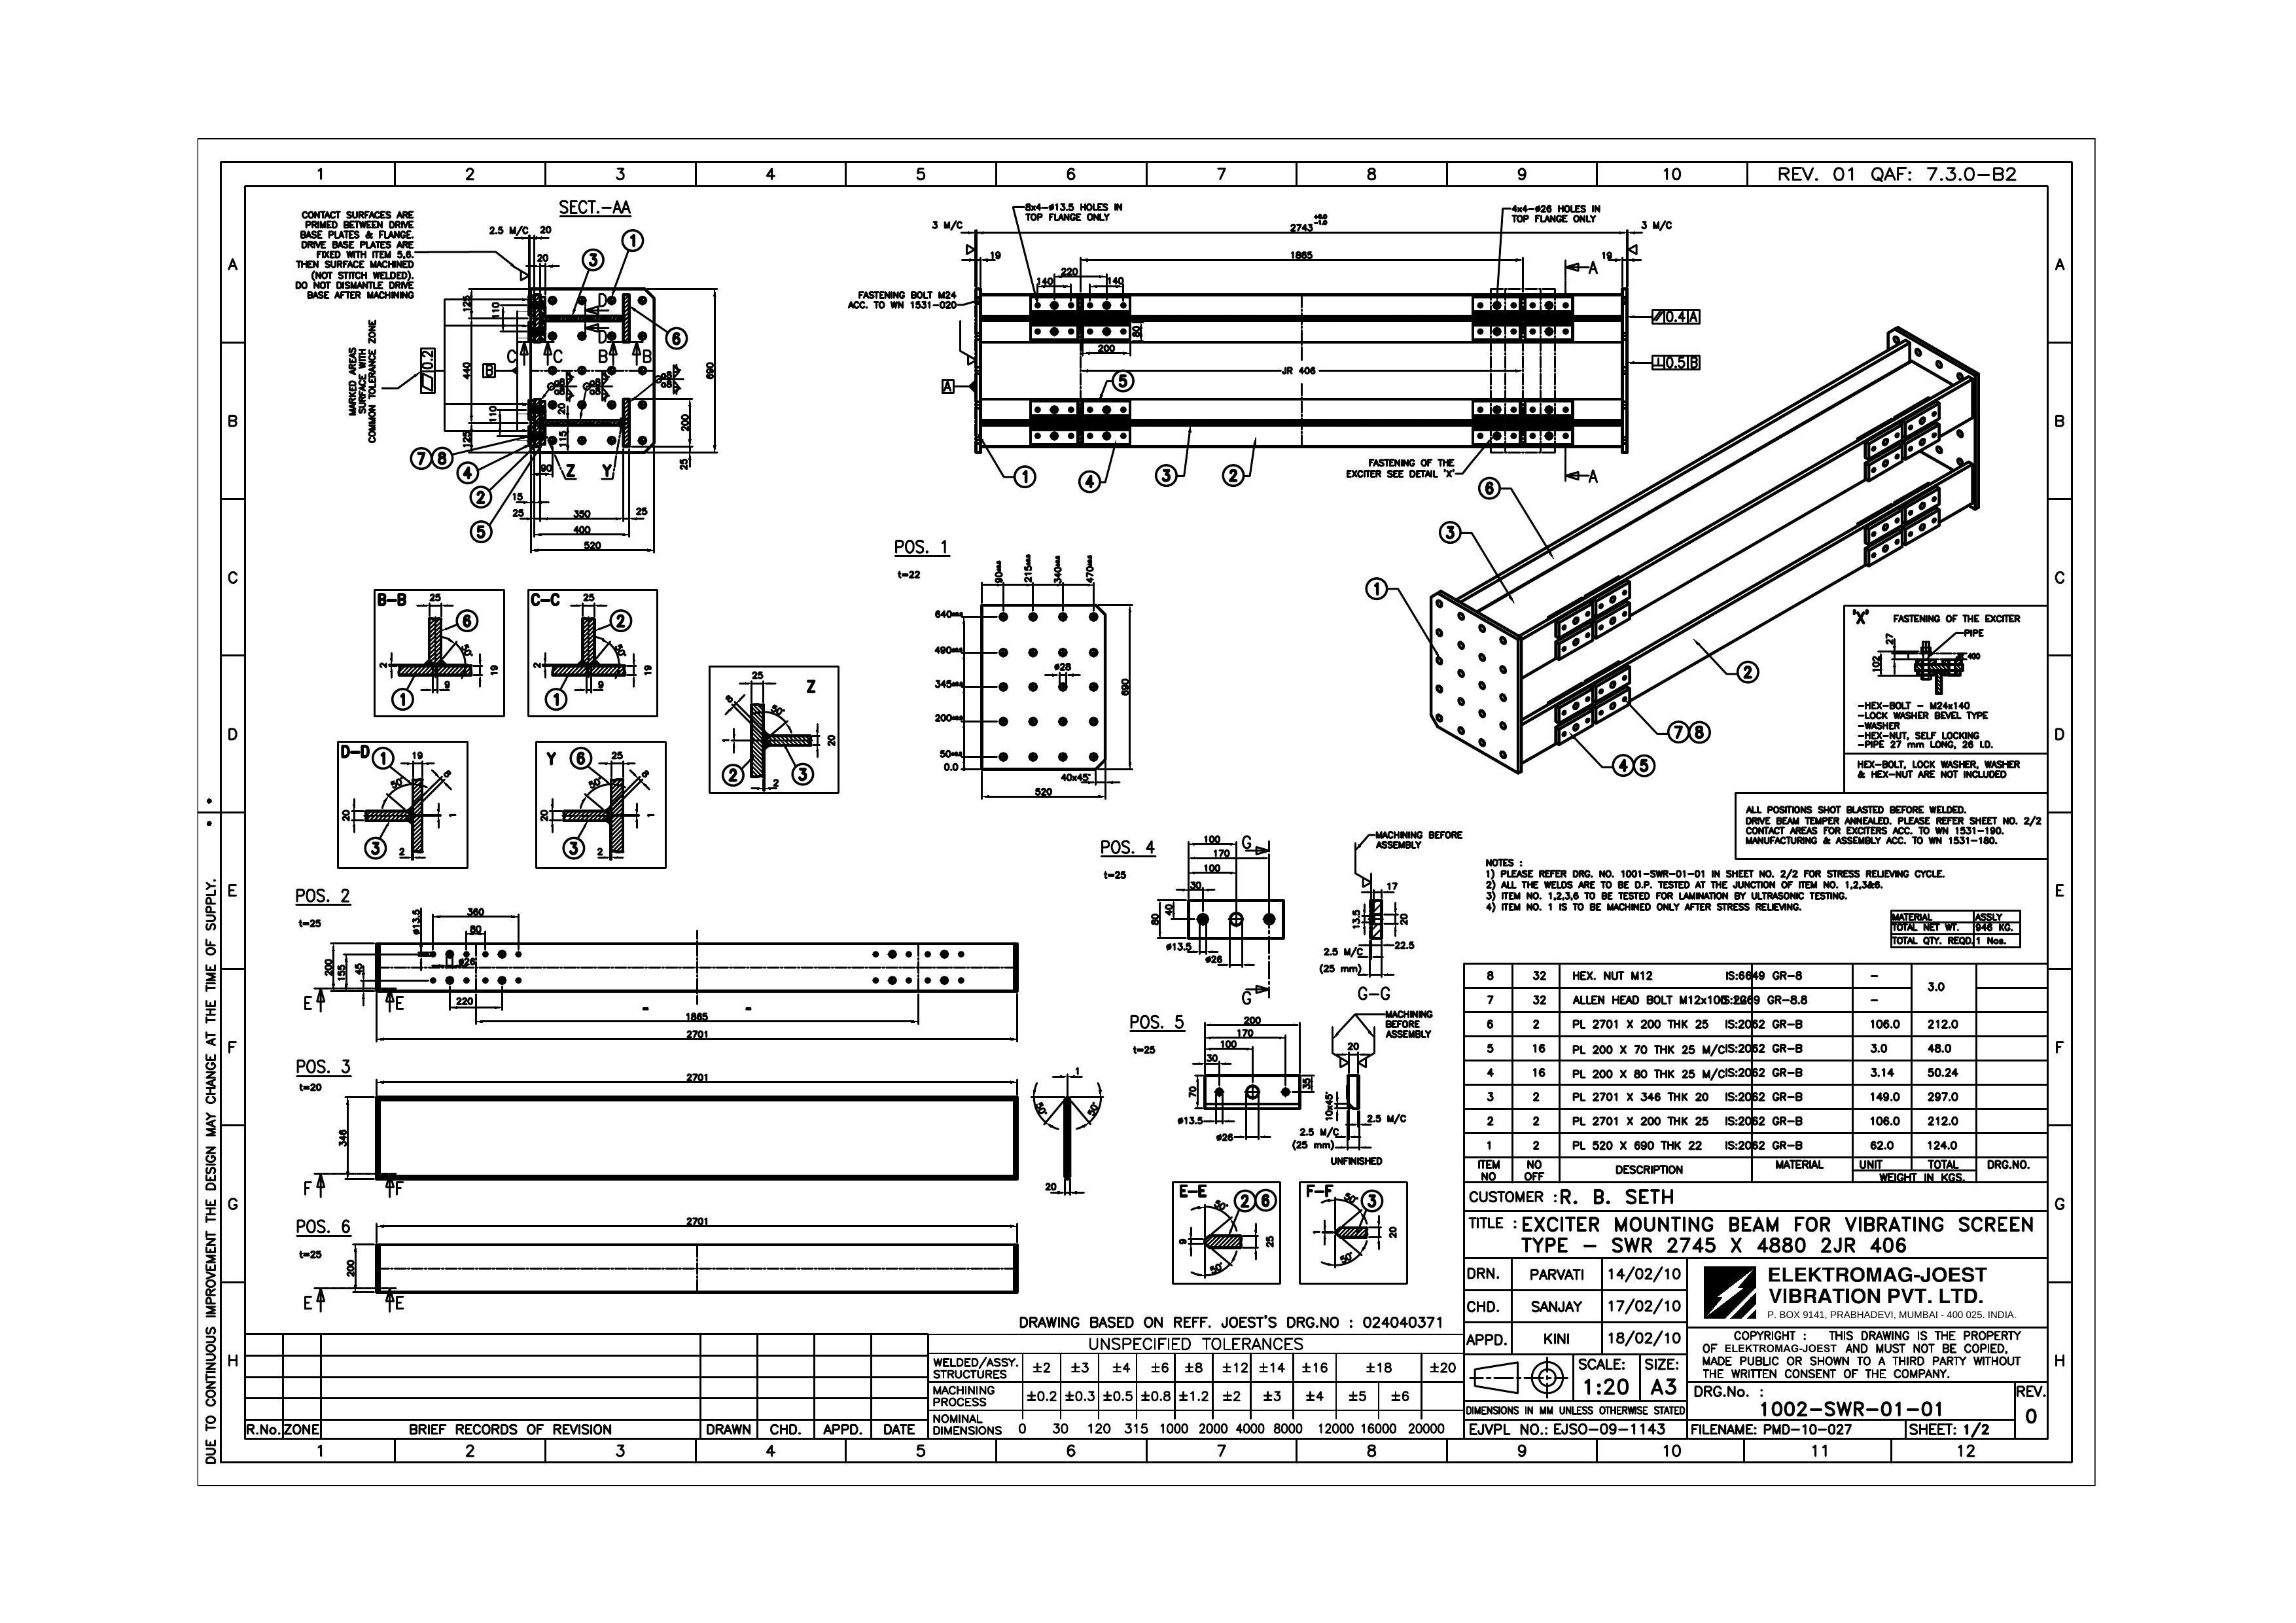

In [215]:
i = 1100

x_path = [df_image_size['image_serial'][i]]
x = cv2.imread(x_path[0])

x_pil = Image.fromarray(x)
display(x_pil)

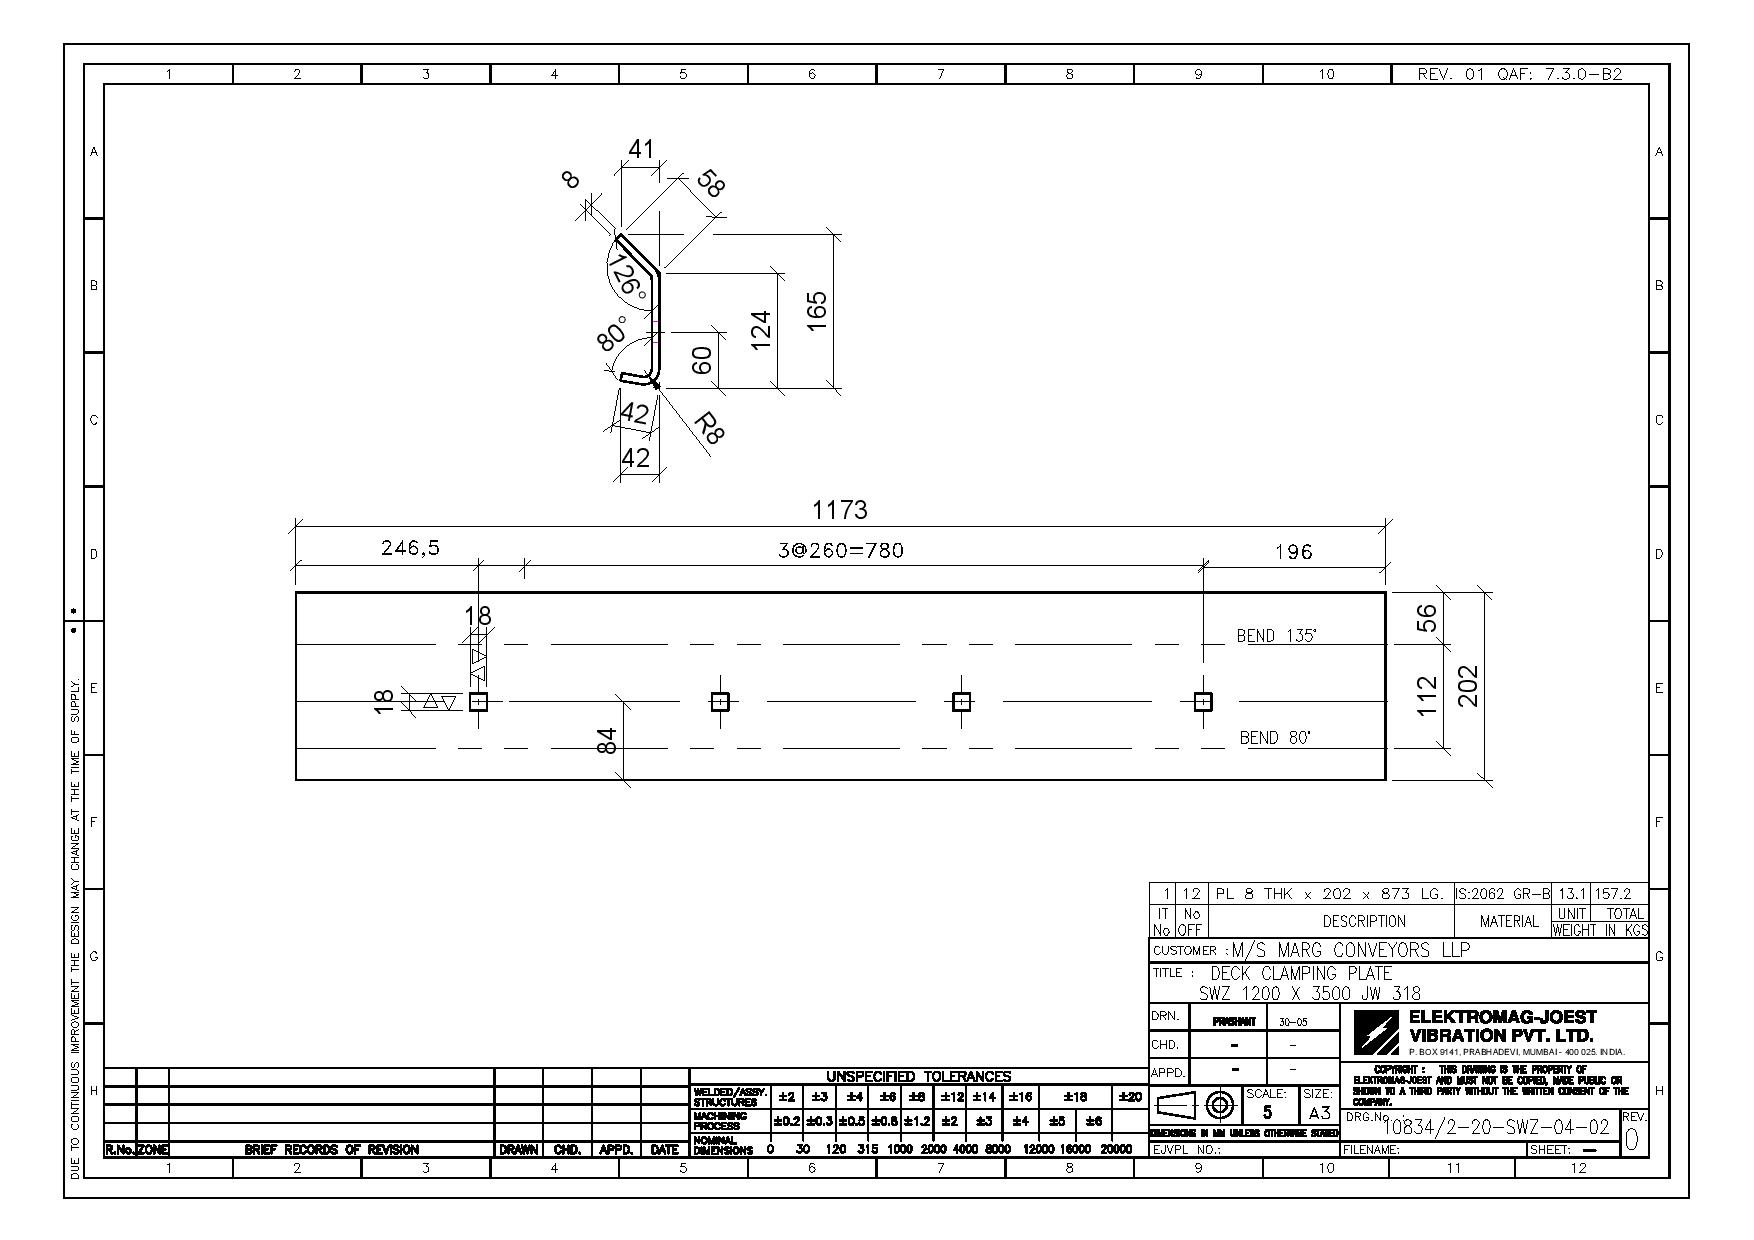

In [24]:
i = 1117

x_path = [df_image_size['image_serial'][i]]
x = cv2.imread(x_path[0])

x_pil = Image.fromarray(x)
display(x_pil)

In [8]:
# Loading output of VGG Image Annotation tool and create a dataframe

region_data = []
r_data = pd.DataFrame()

for i in range(1, 28):
    via_folder = '/Users/subrata/workstation/jupyterFiles/yolo_data_file/via_region_data_drg_test_' + str(i) + '.csv'
    region = pd.read_csv(via_folder)
    region_data.append(region)
    
r_data = pd.concat(region_data).reset_index()

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True) # remove drgs having no bbox info
r_data_master_unique = r_data_master.drop_duplicates('#filename', keep=False).reset_index(drop=True) # remove duplicate rows
r_data_master_unique.drop(r_data_master_unique.columns[[0, 2, 3, 4, 5]], axis=1, inplace=True) # reduce unnecessary columns

num_images_in_data_master = r_data_master_unique["#filename"].nunique()
r_data_master_image_list = r_data_master_unique["#filename"].tolist()


In [281]:
r_data_master_unique.tail(3)

#filename  \
1432  SOM 14 003437 MHIL-Model-1-page-001.jpg   
1433  SOM 14 003437 MHIL-Model-2-page-001.jpg   
1434    SOM 14 003437 MHIL-Model-page-001.jpg   

                               region_shape_attributes region_attributes  
1432  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}  
1433  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}  
1434  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}

In [282]:
print(len(r_data_master_unique))
r_data_master_unique.tail(3)

1435


#filename  \
1432  SOM 14 003437 MHIL-Model-1-page-001.jpg   
1433  SOM 14 003437 MHIL-Model-2-page-001.jpg   
1434    SOM 14 003437 MHIL-Model-page-001.jpg   

                               region_shape_attributes region_attributes  
1432  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}  
1433  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}  
1434  {"name":"rect","x":0,"y":0,"width":0,"height":0}                {}

In [9]:
# Create drg master having bbox information :

reqd_drg_image = []
k = 0

for i in r_data_master_image_list:

    # print(i)
    image_desc = [s for s in drg_image if i in s]
    # print(image_desc)

    if image_desc != []:
        reqd_drg_image.append(image_desc)

    if image_desc == []:
        r_data_master_unique = r_data_master_unique[r_data_master_unique['#filename'] != i]

 #   reqd_drg_image.append(image_desc)
 #   print(reqd_drg_image[k])
    # print('*************************')
 #   k=k+1

r_data_master_unique = r_data_master_unique.reset_index(drop = 'True')
print(len(r_data))         # all data including drgs with no bbox data
print(len(r_data_master))  # data with drgs having bbox information

print(len(r_data_master_unique))
print(len(r_data_master_image_list))

print(num_images_in_data_master)
print(len(drg_image))      # all drg images
print(len(reqd_drg_image)) # drgs having bbox information


1470
1461
1432
1435
1435
1469
1432


In [10]:
reqd_drg_image[0]

['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_1/1001.jpg']

In [8]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_image_size = pd.DataFrame()

for i in range(len(reqd_drg_image)):
 #   print(i)
    bgr_image = cv2.imread(reqd_drg_image[i][0]) ## Loading image
    image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(reqd_drg_image[i][0])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_image_size.insert(loc=0, column='image_serial', value=image_num)
df_image_size.insert(loc=1, column='rows', value=row_values)
df_image_size.insert(loc=2, column='columns', value=col_values)

df_image_size.tail(3)

1432


image_serial  rows  columns
1429  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508
1430  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508
1431  /Users/subrata/workstation/jupyterFiles/yolo_d...  2479     3508

In [288]:
r_attribs = r_data_master_unique.values[1431, 2][1:(len(r_data_master_unique.values[1431, 2])-1)]
r_attribs

''

In [287]:
r_attribs = r_data_master_unique.values[0, 2][1:(len(r_data_master_unique.values[0, 2])-1)]
r_attribs

'"text":"bom"'

In [9]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []  # co-ordinate of bbox left-top corner and NOT center of bbox
y = []  # co-ordinate of bbox left-top corner and NOT center of bbox
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_data_master_unique)):
    
    r_size = r_data_master_unique.values[i, 1][1:(len(r_data_master_unique.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    # print(i)
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
#    print('=================================================')
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_data_master_unique.values[i, 2][1:(len(r_data_master_unique.values[i, 2])-1)]
    if r_attribs == '':
        this_class = 0
    else:
        this_class = 1
    obj_class.append(this_class)
    
    foto_id = r_data_master_unique['#filename'][i]

    # print(foto_id)

    final_image_list = df_image_size['image_serial'].to_list()
    # flat_image_list = [item for sublist in final_image_list for item in sublist]
    # print(final_image_list[0])
    i_path = [s for s in final_image_list if foto_id in s]
    # foto_index = [idx for idx, s in enumerate(final_image_list[:][0]) if foto_id in s][0]
    foto_index = [idx for idx, s in enumerate(final_image_list) if foto_id in s][0]
    

    # print(i)
    # print(i_path)
    # print(type(i_path))
    # print(i_path[0])
    # print(len(i_path))
    # print(foto_index)


    # print('====================================')
    
    
    foto_width = df_image_size['columns'][foto_index]
    foto_height = df_image_size['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_data_master_unique.insert(loc=1, column='img_idx', value=img_index_values)
r_data_master_unique.insert(loc=2, column='i_path', value=img_path_values)
r_data_master_unique.insert(loc=3, column='x', value=x_values)
r_data_master_unique.insert(loc=4, column='y', value=y_values)
r_data_master_unique.insert(loc=5, column='width', value=width_values)
r_data_master_unique.insert(loc=6, column='height', value=height_values)
r_data_master_unique.insert(loc=7, column='obj_class', value=class_values)
r_data_master_unique.insert(loc=8, column='img_wd', value=i_width_values)
r_data_master_unique.insert(loc=9, column='img_ht', value=i_height_values)

r_data_master_unique.drop(r_data_master_unique.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_data_master_unique.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

num_images = len(r_data_master_unique)
print(num_images)

r_data_master_unique.tail(3)


1432


img_id  img_idx  \
1429  SOM 14 003437 MHIL-Model-1-page-001.jpg     1429   
1430  SOM 14 003437 MHIL-Model-2-page-001.jpg     1430   
1431    SOM 14 003437 MHIL-Model-page-001.jpg     1431   

                                                 i_path  x  y  width  height  \
1429  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   
1430  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   
1431  [/Users/subrata/workstation/jupyterFiles/yolo_...  0  0      0       0   

      obj_class  img_wd  img_ht  
1429          0    3508    2479  
1430          0    3508    2479  
1431          0    3508    2479

In [261]:
r_data_master_unique.tail(6)

img_id  img_idx  \
1258  REPL-MFD-650-022-23-Model.jpg     1258   
1259              SHR-23-003-S3.jpg     1259   
1260          SHR-23-170-R2 (1).jpg     1260   
1261     SM-MFD-8.1KW-S07-21-R1.jpg     1261   
1262     SM-MFD-8.5KW-002-22-R1.jpg     1262   
1263                 VSN-23-009.jpg     1263   

                                                 i_path     x     y  width  \
1258  [/Users/subrata/workstation/jupyterFiles/yolo_...     0     0      0   
1259  [/Users/subrata/workstation/jupyterFiles/yolo_...  1562  1037    660   
1260  [/Users/subrata/workstation/jupyterFiles/yolo_...  1414  1060    812   
1261  [/Users/subrata/workstation/jupyterFiles/yolo_...  1389  1247    934   
1262  [/Users/subrata/workstation/jupyterFiles/yolo_...  1529  1249    789   
1263  [/Users/subrata/workstation/jupyterFiles/yolo_...  1592  1069    720   

      height  obj_class  img_wd  img_ht  
1258       0          0    2339    1653  
1259     269          1    2339    1653  
1260     255          1    2339    1653  
1261     205          1    2339    1653  
1262     205          1    2339    1653  
1263     285          1    2339    1653

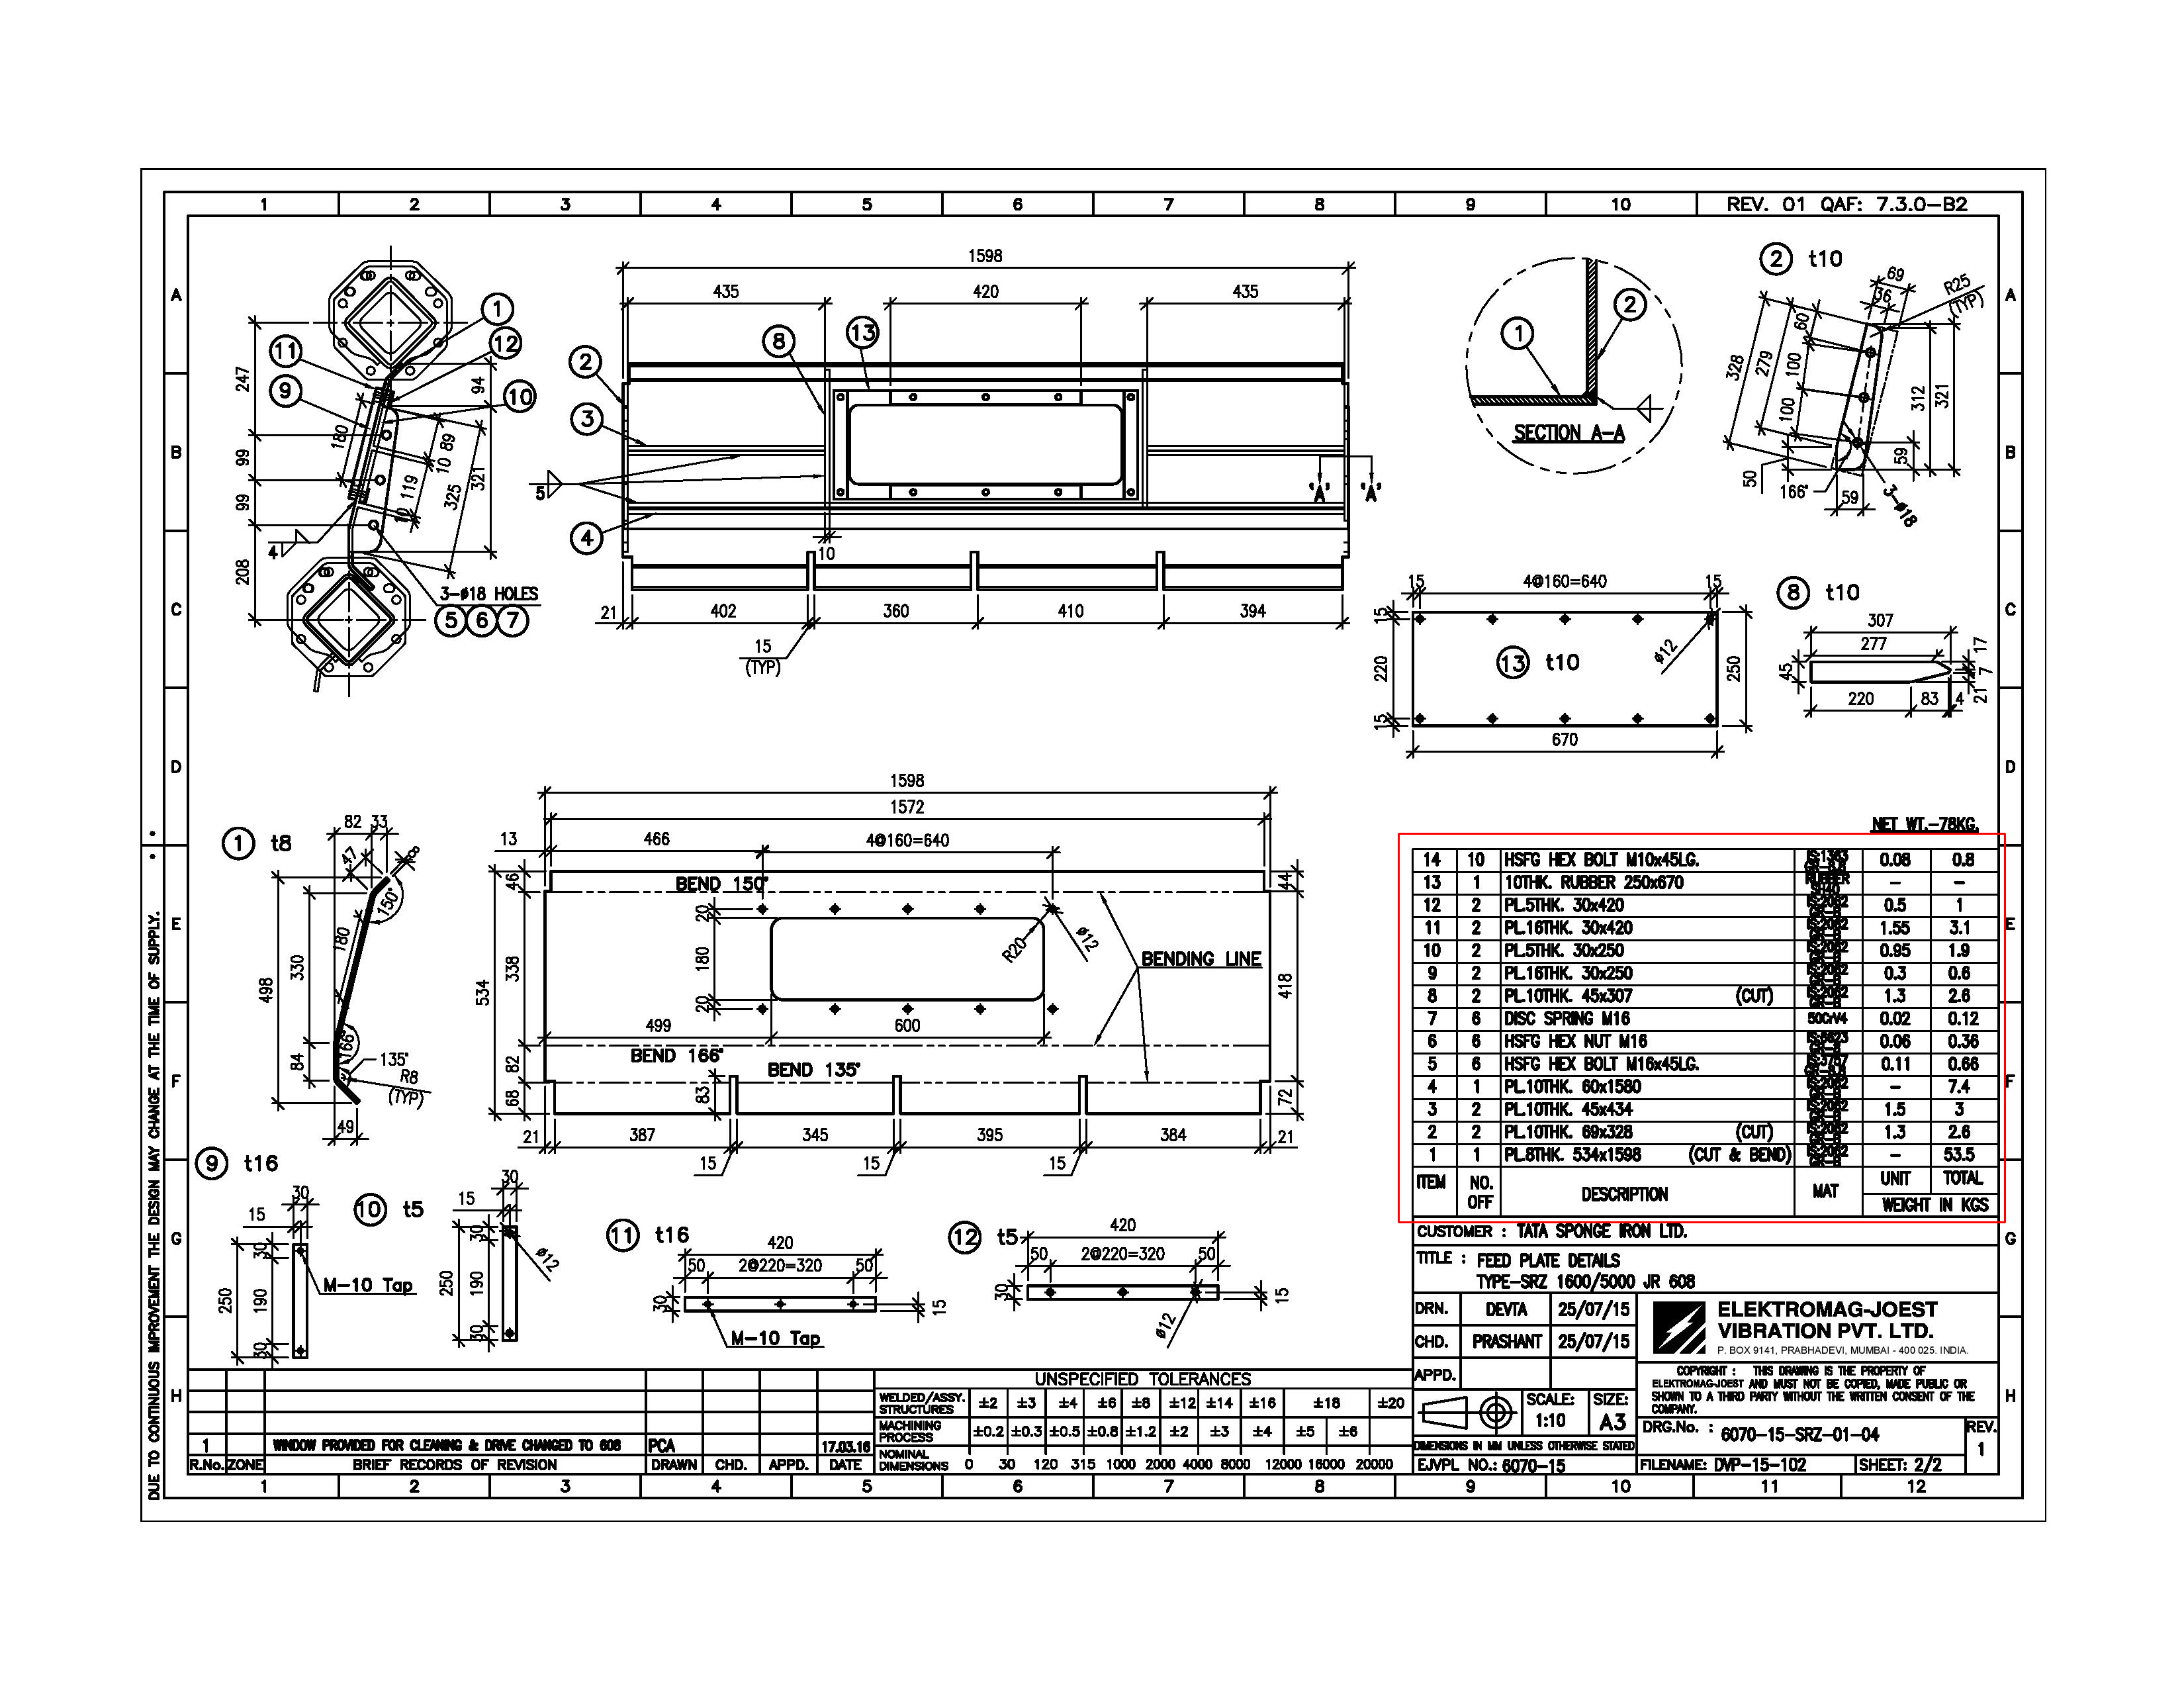

In [53]:
i = 700

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])

x_min = r_data_master_unique['x'][i]
x_max = r_data_master_unique['x'][i] + r_data_master_unique['width'][i]

y_min = r_data_master_unique['y'][i]
y_max = r_data_master_unique['y'][i] + r_data_master_unique['height'][i]

cv2.rectangle(x, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

x_pil = Image.fromarray(x)
display(x_pil)

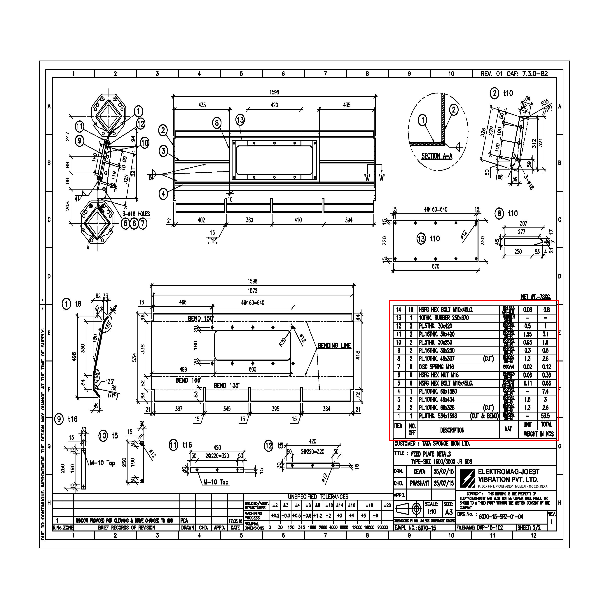

In [54]:
i = 700

x_path = r_data_master_unique['i_path'][i]
x = cv2.imread(x_path[0])
x_resized = cv2.resize(x,(target_size[0], target_size[1]))

img_width = r_data_master_unique['img_wd'][i]
img_height = r_data_master_unique['img_ht'][i]

x_ratio = target_size[1] / img_width
y_ratio = target_size[0] / img_height

x_min_resized = round(r_data_master_unique['x'][i]*x_ratio)
x_max_resized = round(r_data_master_unique['x'][i]*x_ratio + r_data_master_unique['width'][i]*x_ratio)

y_min_resized = round(r_data_master_unique['y'][i] * y_ratio)
y_max_resized = round(r_data_master_unique['y'][i] * y_ratio + r_data_master_unique['height'][i] * y_ratio)

cv2.rectangle(x_resized, (x_min_resized, y_min_resized), (x_max_resized, y_max_resized), (255, 0, 0), 1)

x_pil = Image.fromarray(x_resized)
display(x_pil)

In [10]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        label = lines['obj_class'][i]
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [11]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(num_images):

    image_line = []
    
    img = r_data_master_unique['img_id'][limit_upper]
    kount = r_data_master_unique['img_id'].value_counts()[img]    ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_data_master_unique[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)                                                                  ## line_idx = index of the same image in df_new dataframe
    image_line.append(pic_path)                                                                  ## pic_path = path of the image
    image_line.append(boxes)                                                                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                                                                    ## labels are in form of index no. in 'categories' list 
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[1080])   ##  boxes are in format xmin, ymin, xmax, ymax

1432
[1080, ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_20/SM-MFD-5KW-009-23-Model-page-001.jpg'], array([[0., 0., 0., 0.]], dtype=float32), array([0]), 3508, 2479]


In [12]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.80 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

1432 1145 287


In [293]:
data_train[0]

[1193,
 ['/Users/subrata/workstation/jupyterFiles/yolo_data_file/drg_test_23/OBMS-MFD-16KW-007-23.jpg'],
 array([[1155.,  994., 2314., 1357.]], dtype=float32),
 array([1]),
 2339,
 1653]

In [65]:
data_train[0][3][0]

1

In [13]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,5), np.float32)

for i in range(len(data_train)):

    y_true[0][0] = data_train[i][3][0]
    y_true[0][1] = data_train[i][2][0][0] / data_train[i][4]
    y_true[0][2] = data_train[i][2][0][1] / data_train[i][5]
    y_true[0][3] = data_train[i][2][0][2] / data_train[i][4]
    y_true[0][4] = data_train[i][2][0][3] / data_train[i][5]

    image_y_true.append(y_true)

    img_idx = data_train[i][0]
    bgr_img = cv2.imread(data_train[i][1][0])
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)   
train_image_idx = image_index


In [14]:
print(X_train.shape)
print(type(X_train))
print(Y_train.shape)
print(type(Y_train))
print(len(train_image_idx))
print(type(train_image_idx))

(1145, 608, 608, 3)
<class 'numpy.ndarray'>
(1145, 1, 5)
<class 'numpy.ndarray'>
1145
<class 'list'>


In [103]:
Y_train[0,0,1:]

array([0.64151514, 0.5878431 , 0.9178788 , 0.7239216 ], dtype=float32)

In [74]:
Y_train[0, 0,:1]

array([1.], dtype=float32)

In [104]:
print(Y_train[0,0,:])

[1.         0.64151514 0.5878431  0.9178788  0.7239216 ]


In [105]:
print(Y_train[0,0,:][0])

1.0


In [107]:
print(Y_train[0,0,:1][0])

1.0


In [108]:
print(Y_train[0,0,1:])

[0.64151514 0.5878431  0.9178788  0.7239216 ]


In [15]:
image_index = []
image_resized = []
image_y_true = []

y_true = np.zeros((1,5), np.float32)

for i in range(len(data_val)):

    y_true[0][0] = data_val[i][3][0]
    y_true[0][0] = data_val[i][2][0][0] / data_val[i][4]
    y_true[0][1] = data_val[i][2][0][1] / data_val[i][5]
    y_true[0][2] = data_val[i][2][0][2] / data_val[i][4]
    y_true[0][3] = data_val[i][2][0][3] / data_val[i][5]

    image_y_true.append(y_true)

    img_idx = data_val[i][0]
    bgr_img = cv2.imread(data_val[i][1][0])
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    img_resized = (img_resized - 127.5)/ 255.

    image_index.append(img_idx)
    image_resized.append(img_resized)

X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)   
val_image_idx = image_index


In [16]:
# Classification and localisation loss :
# y_true in shape (xmin, ymin, xmax, ymax, class probability)
"""
def localization_loss_2(y_true, y_pred):
    true_bbox = y_true[..., 1:]  # Updated indexing
    pred_bbox = y_pred[..., 1:]  # Updated indexing
    has_object = tf.reduce_any(y_true[..., :1] != 0, axis=-1)  # Updated axis argument
    
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss
"""
def classification_loss_2(y_true, y_pred):
    true_labels = y_true[..., :1]  # Updated indexing
    pred_probs = y_pred[..., :1]  # Updated indexing
    
    class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, pred_probs))
    
    return class_loss
"""
def localization_loss(y_true, y_pred):
    # Extract the true bounding box coordinates
    true_bbox = y_true[:, 0, 1:]
    
    # Extract the predicted bounding box coordinates
    pred_bbox = y_pred[:, 0, 1:]
    
    # Check if there is an object present
    has_object = tf.reduce_any(y_true[:, 0, :1] != 0, axis=[1, 2])
    
    # Compute the mean squared error (MSE) loss for localization only if there is an object present
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss
"""

def my_custom_loss_2(y_true, y_pred):
    # Compute the total loss as a combination of localization and classification losses
    # loc_loss = localization_loss_2(y_true, y_pred)
    class_loss = classification_loss_2(y_true, y_pred)
    total_loss = class_loss  # + loc_loss
    
    return total_loss


In [17]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


In [18]:
def make_my_model_1():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    x = Dropout(0.2)(x)

    """
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    x = Dropout(0.2)(x)
    
    # Layer 16 => 36
    for i in range(2):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    """  
      
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 36}], skip = False)
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 37}], skip = False)
    # x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38}], skip = False)
    x = Dropout(0.2)(x)
    """
    flat_x = Flatten()(x)
    class_output = Dense(128, activation = 'relu')(flat_x)
    class_output = Dense(1, activation = 'sigmoid')(class_output)

    reg_output = Dense(128, activation = 'relu')(flat_x)
    reg_output = Dense(4, activation = 'linear')(reg_output)

    output_data = tf.keras.layers.concatenate([class_output, reg_output], axis=-1)

    model = Model(input_image, outputs = output_data)
    return model
    """

    flat_x = Flatten()(x)
    class_output = Dense(128, activation='relu')(flat_x)
    class_output = Dense(1, activation='sigmoid')(class_output)

    #reg_output = Dense(128, activation='relu')(flat_x)
    #reg_output = Dense(4, activation='linear')(reg_output)

    #reg_output = tf.expand_dims(reg_output, axis=1)  # Add an extra dimension
    class_output = tf.expand_dims(class_output, axis=1)

    #output_data = tf.keras.layers.concatenate([class_output, reg_output], axis = -1)


    #model = Model(input_image, outputs=output_data)
    model = Model(input_image, class_output)
    return model

In [19]:
input_size = (target_w, target_h, 3)

my_model_1 = make_my_model_1()

print(my_model_1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 608, 608, 32  128         ['conv_0[0][0]']                 
                                )                                                             

In [ ]:

import tensorflow as tf

# Assuming you have a convolutional base and classification/regression head

# Output layer for class prediction
class_output = tf.keras.layers.Dense(1, activation='sigmoid')(classification_head_output)

# Output layer for bounding box regression
bbox_output = tf.keras.layers.Dense(4, activation='linear')(localization_head_output)

# Combine both outputs
output = tf.keras.layers.concatenate([class_output, bbox_output])

In [183]:
# Convolutional base
def make_my_model_vgg():
    # input_shape = (608, 608,, 3)  # Example input shape
    # conv_base = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape)
    conv_base = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
# Classification head
    classification_head = tf.keras.Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# Regression head
    regression_head = tf.keras.Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(4, activation='linear')
    ])

# Combine the base and heads
    input_tensor = conv_base.input
    classification_output = classification_head(conv_base.output)
    regression_output = regression_head(conv_base.output)

# Create the final model
    model_1 = Model(inputs=input_tensor, outputs=[classification_output, regression_output])
    return model_1
# Print model summary
# model.summary


In [184]:
input_size = (target_w, target_h, 3)

my_model_vgg = make_my_model_vgg()

print(my_model_vgg.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 608, 608, 64  1792        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 608, 608, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

In [20]:
epoch = 20
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = my_custom_loss_2)
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/20


2023-05-23 13:16:13.557587: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


72/72 [==============================] - 1116s 15s/step - loss: 0.0182 - val_loss: 3.3125
Epoch 2/20
72/72 [==============================] - 1382s 19s/step - loss: 0.0000e+00 - val_loss: 4.7507
Epoch 3/20
72/72 [==============================] - 1529s 21s/step - loss: 0.0000e+00 - val_loss: 5.3644
Epoch 4/20
72/72 [==============================] - 1361s 19s/step - loss: 0.0000e+00 - val_loss: 5.5890
Epoch 5/20
72/72 [==============================] - 1492s 21s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 6/20
72/72 [==============================] - 1225s 17s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 7/20
72/72 [==============================] - 1285s 18s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 8/20
72/72 [==============================] - 1254s 17s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 9/20
72/72 [==============================] - 1477s 21s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 10/20
63/72 [=========================>....] - ETA: 5:42 - loss:

KeyboardInterrupt: 

In [198]:
epoch = 3
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = my_custom_loss_2)
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/3
55/55 [==============================] - 959s 17s/step - loss: 0.0172 - val_loss: 0.1308
Epoch 2/3
55/55 [==============================] - 1228s 22s/step - loss: 0.0170 - val_loss: 0.1468
Epoch 3/3
55/55 [==============================] - 1230s 22s/step - loss: 0.0167 - val_loss: 0.1431


In [200]:
epoch = 3
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = my_custom_loss_2)
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/3
55/55 [==============================] - 1089s 20s/step - loss: 0.0000e+00 - val_loss: 5.8668
Epoch 2/3
55/55 [==============================] - 1165s 21s/step - loss: 0.0000e+00 - val_loss: 5.8668
Epoch 3/3
55/55 [==============================] - 1066s 19s/step - loss: 0.0000e+00 - val_loss: 5.8668


In [194]:
def localization_loss(y_true, y_pred):
    true_bbox = y_true[:, 0, 1:]
    pred_bbox = y_pred[:, 0, 1:]
    has_object = tf.reduce_any(y_true[:, :, :1] != 0, axis=-1)
    
    loc_loss = tf.where(has_object, tf.reduce_mean(tf.square(true_bbox - pred_bbox)), 0)
    
    return loc_loss

def classification_loss(y_true, y_pred):
    true_labels = y_true[:, :, :1]
    pred_probs = y_pred[:, :, :1]
    
    class_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_labels, pred_probs))
    
    return class_loss

def my_custom_loss(y_true, y_pred):
    loc_loss = localization_loss(y_true, y_pred)
    
    class_loss = classification_loss(y_true, y_pred)
    
    total_loss = loc_loss + class_loss
    
    return total_loss

In [139]:
Y_train[0, 0,:1]

array([1.], dtype=float32)

In [142]:
has_0bject = tf.reduce_any(Y_train[0,0,:1] != 0) #, axis=-1)

In [143]:
reg_output = tf.expand_dims(reg_output, axis=1)  # Add an extra dimension
class_output = tf.expand_dims(class_output, axis=-1)

output_data = tf.keras.layers.concatenate([class_output, reg_output], axis=-1)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [160]:
aa = np.array([1,2,3])
print(aa)
print(aa.shape)
print(type(aa))

[1 2 3]
(3,)
<class 'numpy.ndarray'>


In [161]:
bb = np.array([[4,5,6,7,8,9,10,11,12,13,14,15]])
print(bb)
print(bb.shape)
print(type(bb))

[[ 4  5  6  7  8  9 10 11 12 13 14 15]]
(1, 12)
<class 'numpy.ndarray'>


In [162]:
aa_r = aa.reshape(3,1)
bb_r = bb.reshape(3,4)
print(aa_r)
print(aa_r.shape)
print(bb_r)
print(bb_r.shape)

[[1]
 [2]
 [3]]
(3, 1)
[[ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
(3, 4)


In [163]:
aa_r = tf.expand_dims(aa_r, axis=1)  # Add an extra dimension
bb_r = tf.expand_dims(bb_r, axis=1)
print(aa_r)
print(aa_r.shape)
print('=================================')
print(bb_r)
print(bb_r.shape)

tf.Tensor(
[[[1]]

 [[2]]

 [[3]]], shape=(3, 1, 1), dtype=int64)
(3, 1, 1)
tf.Tensor(
[[[ 4  5  6  7]]

 [[ 8  9 10 11]]

 [[12 13 14 15]]], shape=(3, 1, 4), dtype=int64)
(3, 1, 4)


In [164]:
cc = concatenate([aa_r, bb_r], axis=-1)
dd = concatenate([aa_r, bb_r])

print(cc)
print(type(cc))
print('==========================')
print(dd)
print(type(dd))


tf.Tensor(
[[[ 1  4  5  6  7]]

 [[ 2  8  9 10 11]]

 [[ 3 12 13 14 15]]], shape=(3, 1, 5), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[ 1  4  5  6  7]]

 [[ 2  8  9 10 11]]

 [[ 3 12 13 14 15]]], shape=(3, 1, 5), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [270]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[608, 608, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)

x = Dense(1, activation = 'sigmoid')(x)
model_new_1 = Model(vgg.input, x)
#model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
#plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)
print(model_new_1.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 608, 608, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 608, 608, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 608, 608, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 304, 304, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 304, 304, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 304, 304, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 152, 152, 128)     0  

In [202]:
epoch = 3
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = 'binary_crossentropy')
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/3
55/55 [==============================] - 904s 16s/step - loss: 0.5131 - val_loss: 1.7664
Epoch 2/3
55/55 [==============================] - 982s 18s/step - loss: 0.5112 - val_loss: 1.7906
Epoch 3/3
55/55 [==============================] - 923s 17s/step - loss: 0.5074 - val_loss: 1.7635


In [203]:
epoch = 20

opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model_1.compile(optimizer= opt, loss = 'binary_crossentropy')
history = my_model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/20
55/55 [==============================] - 983s 18s/step - loss: 0.5144 - val_loss: 1.7708
Epoch 2/20
55/55 [==============================] - 1265s 23s/step - loss: 0.5148 - val_loss: 1.7986
Epoch 3/20
55/55 [==============================] - 1248s 23s/step - loss: 0.5111 - val_loss: 1.8025
Epoch 4/20
55/55 [==============================] - 1069s 19s/step - loss: 0.5030 - val_loss: 1.7761
Epoch 5/20
55/55 [==============================] - 1049s 19s/step - loss: 0.4988 - val_loss: 1.7779
Epoch 6/20
55/55 [==============================] - 1064s 19s/step - loss: 0.5127 - val_loss: 1.7613
Epoch 7/20
55/55 [==============================] - 1068s 19s/step - loss: 0.5071 - val_loss: 1.7578
Epoch 8/20
55/55 [==============================] - 1073s 20s/step - loss: 0.5237 - val_loss: 1.7805
Epoch 9/20
55/55 [==============================] - 1035s 19s/step - loss: 0.5172 - val_loss: 1.7970
Epoch 10/20
55/55 [==============================] - 1041s 19s/step - loss: 0.5062 - val_los

In [27]:
model_1 = keras.Sequential([Conv2D(16, (3,3), activation = 'relu', input_shape = (608, 608, 3)), MaxPooling2D((2,2)), 
                    Conv2D(32, (3,3), activation = 'relu'), MaxPooling2D((2,2)),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')])

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 606, 606, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 303, 303, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 301, 301, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 720000)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [28]:
epoch = 25

opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model_1.compile(optimizer= opt, loss = my_custom_loss_2) #, metrics = ['accuracy'])
history = model_1.fit(X_train,Y_train, epochs=epoch, batch_size = 16, validation_data=(X_val,Y_val))

Epoch 1/25
72/72 [==============================] - 146s 2s/step - loss: 0.0102 - val_loss: 5.6017
Epoch 2/25
72/72 [==============================] - 131s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 3/25
72/72 [==============================] - 120s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 4/25
72/72 [==============================] - 115s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 5/25
72/72 [==============================] - 115s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 6/25
72/72 [==============================] - 113s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 7/25
72/72 [==============================] - 112s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 8/25
72/72 [==============================] - 112s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 9/25
72/72 [==============================] - 113s 2s/step - loss: 0.0000e+00 - val_loss: 5.6017
Epoch 10/25
72/72 [==============================] - 110s 2s/step - loss: 0.0